In [2]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
from datetime import timedelta

In [3]:
def lerp(start, end, t):
	r = start[0] + (end[0] - start[0]) * t
	g = start[1] + (end[1] - start[1]) * t
	b = start[2] + (end[2] - start[2]) * t
	a = start[3] + (end[3] - start[3]) * t
	return (r / 255.0, g / 255.0, b / 255.0, a)

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [4]:
# Max 186904
hex_list = ['#85ff00', '#fff100', '#ffaa04', '#ff0000', '#dc00ff', '#6700d4', '#1200db']#, '#0a014a']
scales = [0, 10, 100, 1000, 10000, 100000, 1000000]#, 10000000]
colors = [(0x85, 0xff, 0x00, 1.0), (0xff, 0xf1, 0x00, 1.0), (0xff, 0xaa, 0x04, 1.0), (0xff, 0x00, 0x00, 1.0), (0xdc, 0x00, 0xff, 1.0), (0x67, 0x00, 0xd4, 1.0), (0x12, 0x00, 0xdb, 1.0), (0x12, 0x00, 0xdb, 1.0)]#, (0x0a, 0x01, 0x4a, 1.0), ]

In [5]:
df = pd.read_csv('infected_by_country.csv')
country_names = list(set(df.country.unique()) - set(["?"]))

dates = sorted(list(df.date.unique()))

done = 0
output = {}
first_appearance = {}
for country in country_names:
	c = []
	for d in range(len(dates)):
		if not country in list(df[(df.date == dates[d])]['country']) or df[(df.date == dates[d]) & (df['country'] == country)]['count'].iloc[0] == 0:
			c += [(0, 0, 0, 0)]
		else:
			first_appearance[country] = dates[d]
			v = df[(df.date == dates[d]) & (df['country'] == country)]['count'].iloc[0]
			idx = -1
			for s in range(len(scales) - 1):
				if scales[s] < v and v <= scales[s+1]:
					idx = s
			if idx == -1:
				c += [lerp(colors[-1], colors[-1], 0.5)]
			else:
				c += [lerp(colors[idx], colors[idx+1], (v - scales[idx])/(scales[idx + 1] - scales[idx]))]
	done += 1
	print(f'{str(done).zfill(len(str(len(country_names))))}/{len(country_names)}: {country}')
	output[country] = c


001/236: Grenada
002/236: Israel
003/236: Eritrea
004/236: Bosnia And Herzegovina
005/236: Philippines
006/236: French Polynesia
007/236: Comoros
008/236: Saint Lucia
009/236: Oman
010/236: Malaysia
011/236: Egypt
012/236: Pakistan
013/236: Bolivia
014/236: Holy See (Vatican City State)
015/236: Northern Mariana Islands
016/236: French Guiana
017/236: Burkina Faso
018/236: Germany
019/236: Seychelles
020/236: Djibouti
021/236: British Virgin Islands
022/236: Uruguay
023/236: Morocco
024/236: United Arab Emirates
025/236: Ecuador
026/236: Georgia
027/236: San Marino
028/236: Bahrain
029/236: Cuba
030/236: Senegal
031/236: Costa Rica
032/236: Spain
033/236: Benin
034/236: Norfolk Island
035/236: El Salvador
036/236: Trinidad And Tobago
037/236: Cambodia
038/236: Sint Maarten
039/236: Zimbabwe
040/236: Guatemala
041/236: Namibia
042/236: Palestinian Territories
043/236: Kenya
044/236: Libyan Arab Jamahiriya
045/236: Turkmenistan
046/236: Kuwait
047/236: Uganda
048/236: Saint Kitts And Nev

In [6]:
from json import dumps
jsonified = dumps(output)
with open('./infected-by-country.json', 'w') as f:
    f.write(jsonified)
    f.close()

In [7]:
# Sort infection names initial date (color tuple not 0 0 0 0 ) then alphabetical
appearance = {}
for country in country_names:
    for c in range(len(output[country])):
        if output[country][c][0] != 0 or output[country][c][1] != 0 or output[country][c][2] != 0 or output[country][c][3] != 0:
            appearance[country] = c
            break

appearance_inv = {i: [] for i in range(len(dates))}

for v in sorted(list(appearance.items()), key=lambda x: x[1]):
    appearance_inv[v[1]] += [v[0]]

for i in range(len(dates)):
    if len(appearance_inv[i]) == 0:
        del(appearance_inv[i])
    else:
        appearance_inv[i] = sorted(appearance_inv[i])

country_names_sorted = [x for xs in [v for k, v in appearance_inv.items()] for x in xs][::-1]

In [8]:
norm=LogNorm(vmin=1, vmax=999999)
cmappable = ScalarMappable(norm=norm, cmap=get_continuous_cmap(hex_list=hex_list))

In [9]:
dates = sorted(list(df.date.unique()))
m_dates = mdates.num2date(mdates.datestr2num(dates))
m_dates[-1]

datetime.datetime(2022, 5, 4, 0, 0, tzinfo=datetime.timezone.utc)

001/236: Norfolk Island
002/236: American Samoa
003/236: Montserrat
004/236: St. Helena
005/236: Christmas Island
006/236: St. Pierre And Miquelon
007/236: Northern Mariana Islands
008/236: Holy See (Vatican City State)
009/236: British Indian Ocean Territory
010/236: Aland Islands
011/236: Nauru
012/236: North Korea
013/236: British Virgin Islands
014/236: Federated States Of Micronesia
015/236: Vanuatu
016/236: Turks And Caicos Islands
017/236: Turkmenistan
018/236: Tonga
019/236: Sao Tome And Principe
020/236: San Marino
021/236: Samoa
022/236: Palau
023/236: Mauritania
024/236: Kiribati
025/236: Guinea-Bissau
026/236: Faroe Islands
027/236: Eritrea
028/236: Djibouti
029/236: Comoros
030/236: Anguilla
031/236: Us Virgin Islands
032/236: Tuvalu
033/236: Saint Vincent And The Grenadines
034/236: Liechtenstein
035/236: Greenland
036/236: Chad
037/236: South Sudan
038/236: Jersey
039/236: Bonaire/Sint Eustatius/Saba
040/236: Zimbabwe
041/236: Zambia
042/236: Yemen
043/236: Viet Nam
044/

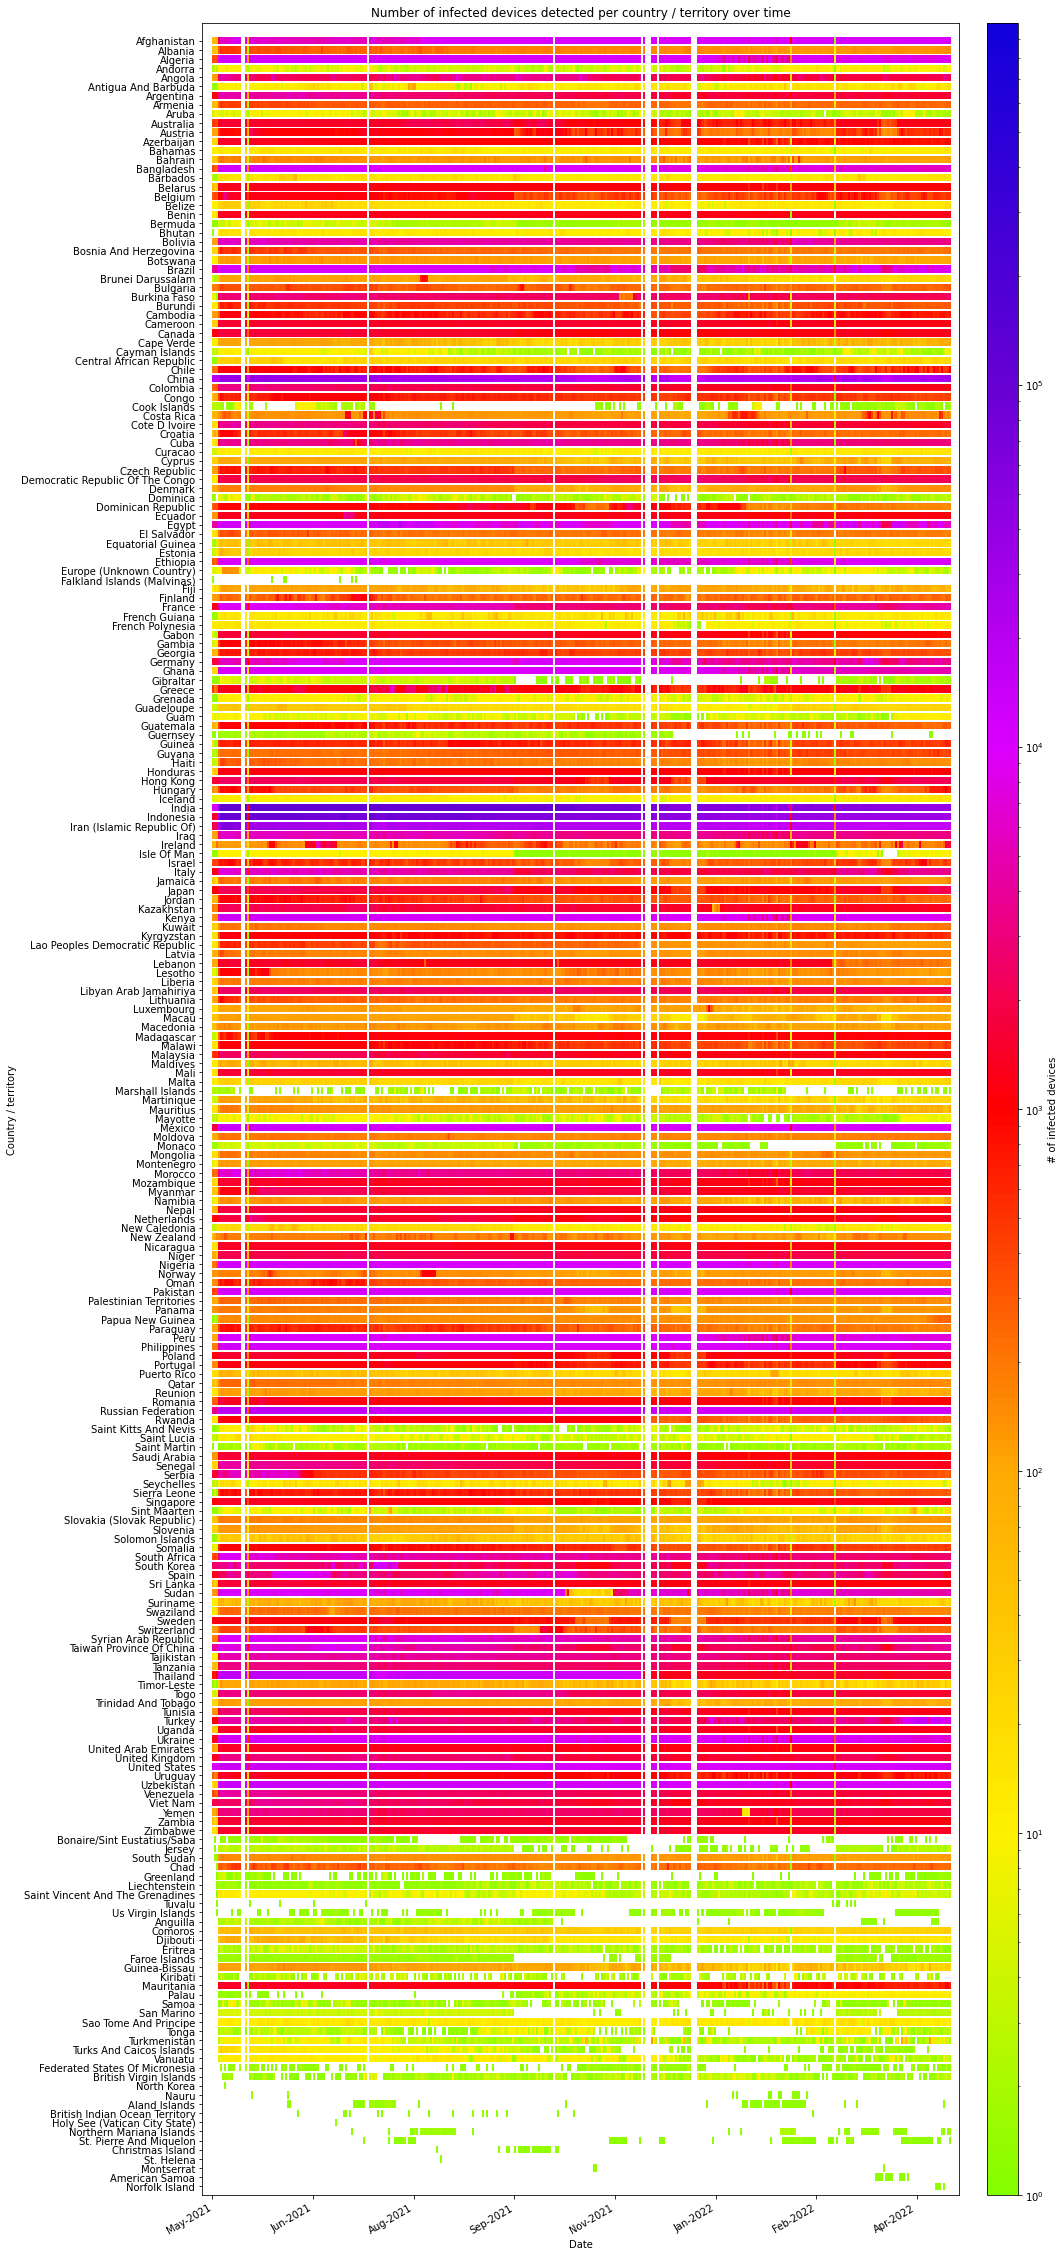

In [10]:

plt.rcParams["figure.figsize"] = (16.54, 44.38)

fig, ax = plt.subplots(figsize=(16.54,44.38))
y = 0
done = 0

for country in country_names_sorted:
	for c in range(len(output[country])):
		ax.barh(y, 1, left= m_dates[c], height=0.8, align='center', color=output[country][c])
	y += 1
	done += 1
	print(f'{str(done).zfill(len(str(len(country_names))))}/{len(country_names)}: {country}')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 
ax.axis('tight')
ax.set_xlim([m_dates[0] - timedelta(days=5), m_dates[-1] + timedelta(days=5)])
ax.set_ylim([-1, len(country_names) + 1])
ax.set_yticks(np.arange(len(country_names)))
ax.set_yticklabels(country_names_sorted)

ax.set_xlabel('Date')
ax.set_ylabel('Country / territory')

fig.autofmt_xdate()

cb =fig.colorbar(cmappable, aspect=70, pad=0.03)
cb.ax.set_ylabel('# of infected devices')

ax.set_title("Number of infected devices detected per country / territory over time")

plt.savefig('../images/infected-bycountry-better.png', facecolor='white', transparent=False, bbox_inches='tight', pad_inches=.2, dpi=300)
plt.show()

In [16]:
stats_df = pd.DataFrame(columns=['country', 'max', 'avg', 'med'])

m = df.groupby(['country']).max().sort_values(by='count', ascending=False).head(10)
a = df.groupby(['country']).mean().sort_values(by='count', ascending=False).head(10)
f = df.groupby(['country']).median().sort_values(by='count', ascending=False).head(10)

for col, tab in zip(['max', 'avg', 'med'], [m, a, f]):
	for i, row in tab.iterrows():
		if i not in stats_df.country.values:
			stats_df = pd.concat([stats_df, pd.DataFrame({'country': [i], col: [row['count']]})])
		else:
			stats_df.loc[stats_df.country == i,col] = row['count']
			
stats_df.to_csv('infected.csv', index=False)

stats_df

TypeError: Cannot index by location index with a non-integer key

In [19]:
stats_df = stats_df.head(10)
stats_df.loc[stats_df.country == 'Egypt', 'avg'] = 11875
stats_df.loc[stats_df.country == 'Egypt', 'med'] = 10817
stats_df.loc[stats_df.country == 'South Korea', 'avg'] = 4574
stats_df.loc[stats_df.country == 'South Korea', 'med'] = 4324
stats_df.loc[stats_df.country == 'Turkey', 'avg'] = 6211
stats_df.loc[stats_df.country == 'Turkey', 'med'] = 5441


stats_df['population'] = [1380004385, 273523615 , 83992949, 143932377, 102334404, 145934462, 51269185 , 69799978 , 84339067 , 128932753]
stats_df['max_scaled'] = stats_df['max'] / (stats_df['population'] / 1000000)
stats_df['avg_scaled'] = stats_df['avg'] / (stats_df['population'] / 1000000)
stats_df['med_scaled'] = stats_df['med'] / (stats_df['population'] / 1000000)

stats_df

,country,max,avg,med,population,max_scaled,avg_scaled,med_scaled
0,India,186904,102266.997183,92779.0,1380004385,135.437251,74.106284,67.230946
0,Indonesia,118260,76966.735211,77468.0,273523615,432.35755,281.389726,283.222346
0,Iran (Islamic Republic Of),81670,38832.760563,38681.0,83992949,972.343524,462.333577,460.526752
0,China,66166,44602.909859,43198.0,143932377,459.701989,309.887954,300.127052
0,Egypt,40477,11875,10817,102334404,395.536578,116.041131,105.702477
0,Russian Federation,39525,24308.183099,23538.0,145934462,270.840756,166.569176,161.29158
0,South Korea,36153,4574,4324,51269185,705.160419,89.215383,84.33916
0,Thailand,33573,14622.146479,18500.0,69799978,480.98869,209.486405,265.043063
0,Turkey,31353,6211,5441,84339067,371.749429,73.643214,64.5134
0,Mexico,25586,16074.557746,16109.0,128932753,198.444533,124.673967,124.9411
